In [83]:
import collections
from etils import epath
from ml_collections import config_dict
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import pandas as pd

from chirp import audio_utils
from chirp.inference import a2o_utils
from chirp.inference import interface
from chirp.inference import tf_examples
from chirp.inference import models
from chirp.models import metrics
from chirp.taxonomy import namespace
from chirp.inference.search import bootstrap
from chirp.inference.search import search
from chirp.inference.search import display
from chirp.inference.classify import classify
from chirp.inference.classify import data_lib
import requests
import json
import pickle
import sys
from scipy.io import wavfile
import os
import re

In [4]:
# Testing
fns = [fn for fn in epath.Path('./embeddings_logits').glob('embeddings-*')]
ds = tf.data.TFRecordDataset(fns)
parser = tf_examples.get_example_parser(['label'])
ds = ds.map(parser)
for ex in ds.as_numpy_iterator():
    print(ex['filename'])
    print(ex['label'])
    print(ex['label'].shape, flush=True)
    break

b'/home/mschulist/caples_sound/ARU_data/10-BLACK/Data/BLACK-10-CAP_20230608_003000.wav'
[[-15.290307  -11.338191  -11.890734  ...  -9.204292   -7.4085484
  -16.3655   ]
 [-14.123681  -10.246731  -10.785428  ...  -8.627625   -7.299284
  -14.387331 ]
 [-13.5969305 -10.529544  -10.584979  ...  -8.731554   -6.6021433
  -14.560753 ]
 ...
 [-15.17115   -11.368123  -12.180693  ...  -9.6179     -7.62348
  -16.14294  ]
 [-14.343305  -11.474348  -11.434666  ...  -9.330857   -8.125924
  -15.421481 ]
 [-15.248545  -11.199123  -12.174236  ...  -9.440248   -7.740094
  -15.679293 ]]
(248, 118)


In [16]:
# load embedding config
working_dir =  '.'
embeddings_path = epath.Path(working_dir) / 'embeddings'
labeled_data_path = epath.Path(working_dir) / 'labeled_outputs'
custom_classifier_path = epath.Path(working_dir) / 'custom_classifier'
bootstrap_config = bootstrap.BootstrapConfig.load_from_embedding_path(
      embeddings_path=embeddings_path,
      annotated_path=labeled_data_path)

project_state = bootstrap.BootstrapState(
    bootstrap_config, a2o_auth_token='')
window_s = bootstrap_config.model_config['window_size_s']
sample_rate = bootstrap_config.model_config['sample_rate']
hop_size_s = bootstrap_config.model_config['hop_size_s']

In [97]:
fns = [fn for fn in epath.Path('./embeddings_logits').glob('embeddings-*')]
ds = tf.data.TFRecordDataset(fns)
parser = tf_examples.get_example_parser(['label'])
ds = ds.map(parser)

labels = pd.read_csv('./embeddings_logits/logit_index.csv', names=['index', 'code', 'code_suffix'])
labels = labels['code'].to_list()

output_filepath = './outputs_predefined_logits/logit_test.csv'

with open(output_filepath, 'w') as f:
    headers = ['filename', 'timestamp_s', 'label', 'logit']
    f.write(','.join(headers) + '\n')
    for ex in tqdm(ds.as_numpy_iterator()):
        for t in range(ex['label'].shape[0]):
            for i, label in enumerate(labels):
                offset = ex['timestamp_s'] + t * hop_size_s
                logit = '{:2f}'.format(ex['label'][t, i]) # label is key for logit in embeddings...
                row = [
                    ex['filename'].decode('utf-8'),
                    '{:.2f}'.format(offset),
                    label,
                    logit,
                ]
                f.write(','.join(row) + '\n')

123it [00:12,  9.59it/s]2024-06-09 18:31:48.403980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: DATA_LOSS: truncated record at 170614038' failed with Read less bytes than requested
123it [00:12,  9.52it/s]


DataLossError: {{function_node __wrapped__IteratorGetNext_output_types_12_device_/job:localhost/replica:0/task:0/device:CPU:0}} truncated record at 170614038' failed with Read less bytes than requested [Op:IteratorGetNext] name: 

In [98]:
parquet_filepath = f'{output_filepath[:-4]}.parquet'
pd.read_csv(output_filepath).to_parquet(parquet_filepath)

In [99]:
logits = pd.read_parquet(parquet_filepath)

In [100]:
logits.sort_values('logit', ascending=False, inplace=True)

In [101]:
logits[logits['logit'] > 2]

,filename,timestamp_s,label,logit
2351974,/home/mschulist/caples_sound/ARU_data/10-BLACK...,455.0,yerwar,7.206549
2352800,/home/mschulist/caples_sound/ARU_data/10-BLACK...,490.0,yerwar,6.586554
2351148,/home/mschulist/caples_sound/ARU_data/10-BLACK...,420.0,yerwar,6.065564
2354334,/home/mschulist/caples_sound/ARU_data/10-BLACK...,555.0,yerwar,5.448690
2351738,/home/mschulist/caples_sound/ARU_data/10-BLACK...,445.0,yerwar,5.084096
3281015,/home/mschulist/caples_sound/ARU_data/10-BLACK...,145.0,comnig,4.602236
1835633,/home/mschulist/caples_sound/ARU_data/10-BLACK...,900.0,comnig,4.254020
3284909,/home/mschulist/caples_sound/ARU_data/10-BLACK...,310.0,comnig,4.156360
2349614,/home/mschulist/caples_sound/ARU_data/10-BLACK...,355.0,yerwar,3.943126
2352446,/home/mschulist/caples_sound/ARU_data/10-BLACK...,475.0,yerwar,3.909207


In [79]:
def show_classified_spec(filename, offset_s, sample_rate):
    audio = audio_utils.load_audio(f'/{filename}', sample_rate)
    start = int(offset_s * sample_rate)
    end = start + int(5 * sample_rate)
    audio_snippet = audio[start:end]
    display.plot_audio_melspec(audio_snippet, sample_rate)

def show_spec_classified_species(species, classified, n, audio_path, sample_rate):
    filtered = classified[classified['label'] == species]
    filtered = filtered.sort_values(by=['logit'], ascending=False)
    # filtered = filtered[filtered['logit'] > 2]
    for i, window in enumerate(filtered.iterrows()):
        if i < n:
            filename = window[1]['filename']
            offset_s = window[1]['timestamp_s']
            logit = window[1]['logit']
            print(f'species: {species}, logit: {logit}, filename: {filename}, offset: {offset_s}')
            show_classified_spec(f'./{audio_path}/{filename}', offset_s, sample_rate)

species: purfin, logit: 2.298751, filename: /home/mschulist/caples_sound/ARU_data/10-BLACK/Data/BLACK-10-CAP_20230610_093000.wav, offset: 1125.0


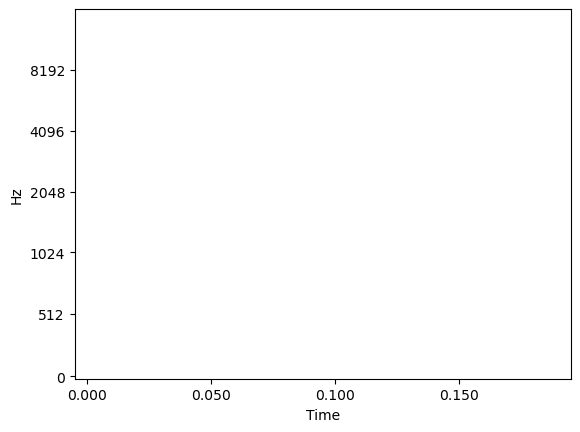

/home/mschulist/miniconda3/envs/caples/lib/python3.10/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767
/home/mschulist/miniconda3/envs/caples/lib/python3.10/site-packages/IPython/lib/display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


species: purfin, logit: 0.977657, filename: /home/mschulist/caples_sound/ARU_data/10-BLACK/Data/BLACK-10-CAP_20230610_093000.wav, offset: 1090.0


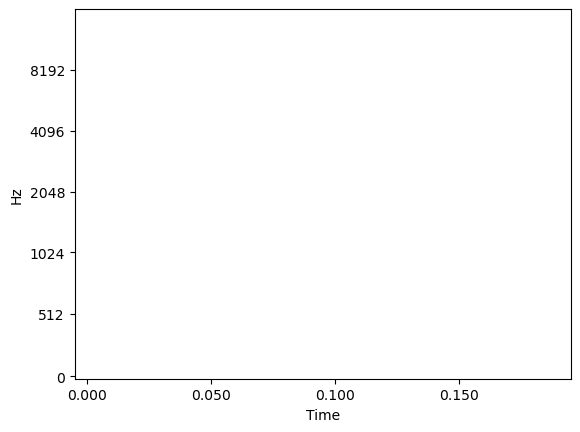

/home/mschulist/miniconda3/envs/caples/lib/python3.10/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767
/home/mschulist/miniconda3/envs/caples/lib/python3.10/site-packages/IPython/lib/display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


species: purfin, logit: 0.858083, filename: /home/mschulist/caples_sound/ARU_data/10-BLACK/Data/BLACK-10-CAP_20230607_090000.wav, offset: 1200.0


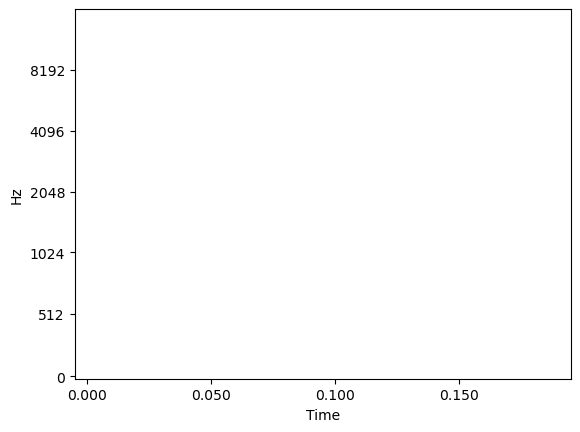

/home/mschulist/miniconda3/envs/caples/lib/python3.10/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767
/home/mschulist/miniconda3/envs/caples/lib/python3.10/site-packages/IPython/lib/display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


species: purfin, logit: 0.83207, filename: /home/mschulist/caples_sound/ARU_data/10-BLACK/Data/BLACK-10-CAP_20230606_160000.wav, offset: 815.0


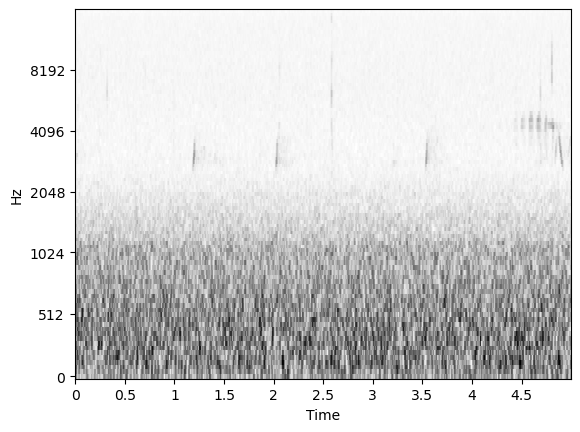

species: purfin, logit: 0.703038, filename: /home/mschulist/caples_sound/ARU_data/10-BLACK/Data/BLACK-10-CAP_20230610_093000.wav, offset: 1185.0


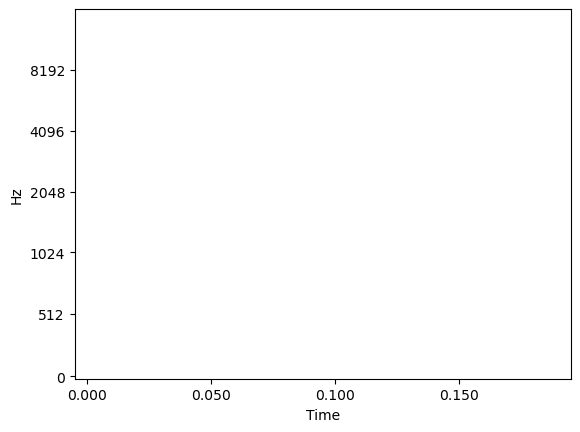

/home/mschulist/miniconda3/envs/caples/lib/python3.10/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767
/home/mschulist/miniconda3/envs/caples/lib/python3.10/site-packages/IPython/lib/display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


In [104]:
show_spec_classified_species('purfin', logits, 5, '', sample_rate)